# 深度學習DL
### 中電會四月主題課程(2024/4/13)

<table class="tfo-notebook-buttons" align="left">
  <td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ChiuDeYuan/SCAICT_lecture/blob/main/0413/housing_price_deeplearning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/ChiuDeYuan/SCAICT_lecture/blob/main/0413/housing_price_deeplearning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
</table>

## Useful links

* Housing Prices Dataset : https://www.kaggle.com/datasets/yasserh/housing-prices-dataset
* Deep Learning (Pytorch) : https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

## Imports
本範例使用pytorch建構神經網路<br>
sklearn進行部分資料處理

In [57]:
# 使用pytorch建構神經網路
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn

In [58]:
# 使用sklearn進行部分資料處理
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

In [59]:
# 跟一些數學運算相關
import numpy as np

# 畫圖用
import matplotlib.pyplot as plt

# 讀取資料用
import pandas as pd

## 定義資料類別
pytorch需要傳入可迭代的資料集物件<br>
這個物件是由 torch.utils.data 中的 Dataset 繼承而來(見上方imports)<br><br>
資料集物件必須包含\_\_init__( )、\_\_len__( )、\_\_getitem\_\_( )<br>
然後我又在這個物件中定義了其他資料處理的method<br><br>
\_\_init__( )是用來初始化資料集<br>
\_\_len__( )回傳資料集的資料筆數<br>
\_\_getitem__( )會根據index回傳一筆資料<br><br>
select( )用來選擇特徵<br>
map_features( )將yes/no的標記轉換成1/0以用於數學運算<br>
scale( )用於縮放數據<br>
head( )會顯示前num筆資料<br>
shape( )回傳資料集的形狀<br>

In [60]:
class HousingPriceDataset(Dataset):

    def __init__(self, path, is_train=True):
        self.dataset = pd.read_csv(path)    # 讀資料
        self.dataset = shuffle(self.dataset, random_state=0)    # 打亂資料

        if(is_train):   # 分割資料集
            self.dataset = self.dataset[:-60]
        else:
            self.dataset = self.dataset[-60:]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        label = self.dataset.iloc[idx, 0]
        features = self.dataset.iloc[idx, 1:]

        # 將dataframe型態資料轉換成tensor
        label = torch.tensor(label)
        features = torch.tensor(features.values)

        label = label.unsqueeze(0)  # 避免tensor維度自動被降低
        label = label.float()   # 將double轉成float
        features = features.float() # 將double轉成float

        return features, label

    def select(self, support):
        self.dataset = self.dataset[support]

    def map_features(self, mapped_var, map_func):
        self.dataset[mapped_var] = self.dataset[mapped_var].apply(map_func)

    def scale(self, scaler, vars):
        self.dataset[vars] = scaler.fit_transform(self.dataset[vars])

    def head(self, num=5):
        print(self.dataset.head(num))

    def shape(self):
        return self.dataset.shape


## Loads data

In [61]:
dataset_path = 'https://raw.githubusercontent.com/ChiuDeYuan/SCAICT_lecture/main/datasets/Housing.csv'

dataset_train = HousingPriceDataset(dataset_path, True)     # 定義訓練集
dataset_val = HousingPriceDataset(dataset_path, False)      # 定義驗證集

In [62]:
dataset_train.shape()

(485, 13)

In [63]:
dataset_val.shape()

(60, 13)

In [64]:
dataset_train.head()

       price   area  bedrooms  bathrooms  stories mainroad guestroom basement  \
239  4585000   4000         3          1        2      yes        no       no   
113  6083000   9620         3          1        1      yes        no      yes   
325  4007500   3460         4          1        2      yes        no       no   
66   6930000  13200         2          1        1      yes        no      yes   
479  2940000   3660         4          1        2       no        no       no   

    hotwaterheating airconditioning  parking prefarea furnishingstatus  
239              no              no        1       no        furnished  
113              no              no        2      yes        furnished  
325              no             yes        0       no   semi-furnished  
66              yes              no        1       no        furnished  
479              no              no        0       no      unfurnished  


## 選擇特徵

In [65]:
# 要用的features
support = ['price', 'area', 'bathrooms', 'stories', 'airconditioning', 'parking']

dataset_train.select(support)
dataset_val.select(support)

## 將yes/no轉1/0
因為數字才能進行數學運算

In [66]:
# 需要轉換的特徵
mapped_var = ['airconditioning']

# 定義映射函數
def map_func(x):
    return x.map({'yes':1 , 'no':0})

In [67]:
dataset_train.map_features(mapped_var, map_func)
dataset_val.map_features(mapped_var, map_func)

In [68]:
dataset_train.head()

       price   area  bathrooms  stories  airconditioning  parking
239  4585000   4000          1        2                0        1
113  6083000   9620          1        1                0        2
325  4007500   3460          1        2                1        0
66   6930000  13200          1        1                0        1
479  2940000   3660          1        2                0        0


In [69]:
dataset_val.head()

       price  area  bathrooms  stories  airconditioning  parking
203  4900000  5400          1        2                0        0
84   6510000  3760          1        2                0        2
426  3353000  2700          1        1                0        0
121  5950000  7231          1        2                1        0
538  1890000  3649          1        1                0        0


## 縮放數據
使用sklearn提供的standard scaler<br>
standard scaler會將數據減去平均值再除以標準差

In [70]:
scaler = StandardScaler()
# 也可以試試scaler = MinMaxScaler()將資料縮放至0~1

vars = ['area', 'bathrooms', 'stories', 'price', 'parking']

In [71]:
dataset_train.scale(scaler, vars)
dataset_val.scale(scaler, vars)

In [72]:
dataset_train.head()

        price      area  bathrooms   stories  airconditioning   parking
239 -0.099922 -0.534982  -0.585859  0.234231                0  0.377742
113  0.694817  2.021552  -0.585859 -0.936925                0  1.544653
325 -0.406305 -0.780628  -0.585859  0.234231                1 -0.789169
66   1.144179  3.650092  -0.585859 -0.936925                0  0.377742
479 -0.972650 -0.689648  -0.585859  0.234231                0 -0.789169


In [73]:
dataset_val.head()

        price      area  bathrooms   stories  airconditioning   parking
203  0.107838  0.240488  -0.447214  0.155752                0 -0.948304
84   1.037647 -0.625152  -0.447214  0.155752                0  1.327626
426 -0.785587 -1.184651  -0.447214 -0.882596                0 -0.948304
121  0.714235  1.206943  -0.447214  0.155752                1 -0.948304
538 -1.630501 -0.683741  -0.447214 -0.882596                0 -0.948304


## Dataloader
dataloader是定義模型讀取資料的方式<br>

In [74]:
# batch_size指定一次更新會看過的資料數量
dataloader_train = DataLoader(dataset = dataset_train, batch_size = 16, shuffle = True)
dataloader_val = DataLoader(dataset = dataset_val, batch_size = 16)

## Build model
pytorch需要定義一個模型類

### 定義模型
創建模型類別

In [75]:
class Model(nn.Module):

    def __init__(self, input_dim, hidden_dim, ouput_dim):
        super(Model, self).__init__()   # 初始化繼承自父類(nn.Module)的屬性


        # linear層就是全連接層
        # 三個參數表示如下:
        # torch.nn.Linear(輸入的特徵維度(上一層神經元數量), 輸出的特徵維度(這一層神經元數量), 是否加入常數項(bias))

        # input layer
        self.linear_1 = torch.nn.Linear(input_dim, input_dim)   # 線性部分(即全連接層)
        self.relu_1 = torch.nn.ReLU(inplace=True)   # 在全連接層後再加一層relu

        # hidden layer
        self.linear_2 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu_2 = torch.nn.ReLU(inplace=True)

        # output layer
        self.linear_3 = torch.nn.Linear(hidden_dim, ouput_dim)
        self.relu_3 = torch.nn.ReLU(inplace=True)

    def forward(self, x):

        # 餵資料
        x = self.linear_1(x)
        x = self.relu_1(x)
        x = self.linear_2(x)
        x = self.relu_2(x)
        x = self.linear_3(x)
        x = self.relu_3(x)

        return x

In [76]:
# 輸入層神經元數由特徵數量決定
# 隱藏層神經元數介於輸入層與輸出層間
# 輸出層神經元數為 類別數量-1(classification) 或 1(regression)
input_dim = 5
hidden_dim = 3
ouput_dim = 1

In [77]:
model = Model(input_dim, hidden_dim, ouput_dim) # 創建模型

### 選擇損失函數
使用MSE作為loss function

In [78]:
# for training
cost = nn.MSELoss()

In [79]:
# for validation
cost_val = nn.MSELoss()

### 設定優化器
adam指的是Adaptive Moment Estimation<br>
所以adam可視為動量(momentum)和自適應學習率(adaptive learning rate)的結合

In [80]:
optimizer = torch.optim.Adam(model.parameters())    # model.parameters()指的是優化目標

## 訓練模型

In [81]:
# 訓練次數
# 30是我隨便指定的(?
epoch_num = 30

In [82]:
# 紀錄loss用
hist_train = []
hist_val = []

In [83]:
for epoch in range(epoch_num):

    loss_train =0
    loss_val = 0

    for data in dataloader_train:

        features, label = data
        outputs = model(features)

        optimizer.zero_grad()    # 把前次計算梯度歸零
        loss = cost(outputs, label)     # 算loss
        loss.backward()     # 反向傳播loss
        optimizer.step()     # 更新權重

        loss_train += loss.data

    for data_val in dataloader_val:

        features_val, label_val = data_val
        prediction = model(features_val)
        loss = cost_val(prediction, label_val)
        loss_val += loss.data

    hist_train.append(loss_train/len(dataloader_train))
    hist_val.append(loss_val/len(dataloader_val))

    print(f"[{epoch+1}/{epoch_num}] loss_train:{loss_train/len(dataloader_train)} loss_val:{loss_val/len(dataloader_val)}")

[1/30] loss_train:0.9390435218811035 loss_val:0.9401813745498657
[2/30] loss_train:0.8908385634422302 loss_val:0.9243869185447693
[3/30] loss_train:0.9099316000938416 loss_val:0.9093277454376221
[4/30] loss_train:0.9031494855880737 loss_val:0.8967853784561157
[5/30] loss_train:0.8675193786621094 loss_val:0.884998083114624
[6/30] loss_train:0.8545876741409302 loss_val:0.8740482330322266
[7/30] loss_train:0.9114968180656433 loss_val:0.864726185798645
[8/30] loss_train:0.8368725776672363 loss_val:0.8503628969192505
[9/30] loss_train:0.8176792860031128 loss_val:0.8354955911636353
[10/30] loss_train:0.8045827150344849 loss_val:0.8142554759979248
[11/30] loss_train:0.7809873819351196 loss_val:0.7854546308517456
[12/30] loss_train:0.7483446598052979 loss_val:0.7555387020111084
[13/30] loss_train:0.7284954190254211 loss_val:0.7194572687149048
[14/30] loss_train:0.7169989943504333 loss_val:0.687207043170929
[15/30] loss_train:0.7183608412742615 loss_val:0.6595468521118164
[16/30] loss_train:0.6

## 畫出loss訓練歷程

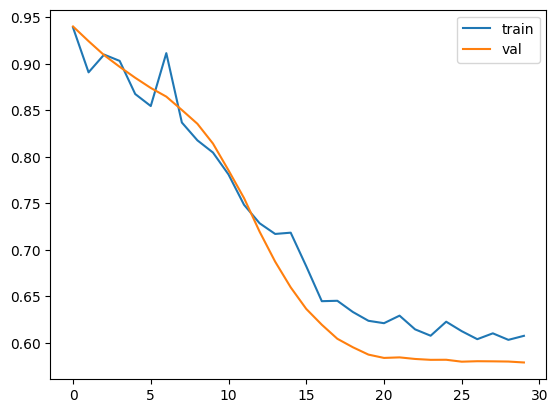

In [84]:
plt.plot(hist_train, label='train')
plt.plot(hist_val, label='val')
plt.legend(loc='upper right')
plt.show()